In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()


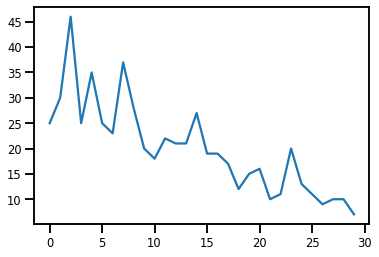

In [3]:
num_timesteps = 30
observed_counts = np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_timesteps, 5, num=num_timesteps)), 0.20, size=num_timesteps)) 
observed_counts = observed_counts.astype(np.float32)
plt.plot(observed_counts)

In [4]:
def build_model(approximate_unconstrained_rates):
  trend = tfp.sts.LocalLinearTrend(
      observed_time_series=approximate_unconstrained_rates)
  return tfp.sts.Sum([trend],
                     observed_time_series=approximate_unconstrained_rates)


In [5]:
positive_bijector = tfb.Softplus()  # Or tfb.Exp()

# Approximate the unconstrained Poisson rate just to set heuristic priors.
# We could avoid this by passing explicit priors on all model params.
approximate_unconstrained_rates = positive_bijector.inverse(
    tf.convert_to_tensor(observed_counts) + 0.01)
sts_model = build_model(approximate_unconstrained_rates)


In [6]:
def sts_with_poisson_likelihood_model():
  # Encode the parameters of the STS model as random variables.
  param_vals = []
  for param in sts_model.parameters:
    param_val = yield param.prior
    param_vals.append(param_val)

  # Use the STS model to encode the log- (or inverse-softplus)
  # rate of a Poisson.
  unconstrained_rate = yield sts_model.make_state_space_model(
      num_timesteps, param_vals)
  rate = positive_bijector.forward(unconstrained_rate[..., 0])
  observed_counts = yield tfd.Poisson(rate, name='observed_counts')

model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)


In [9]:
pinned_model = model.experimental_pin(observed_counts=observed_counts)

In [8]:
constraining_bijector = pinned_model.experimental_default_event_space_bijector()

In [10]:
# Allow external control of sampling to reduce test runtimes.
num_results = 500 # @param { isTemplate: true}
num_results = int(num_results)

num_burnin_steps = 100 # @param { isTemplate: true}
num_burnin_steps = int(num_burnin_steps)


In [11]:
sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=pinned_model.unnormalized_log_prob,
        step_size=0.1),
    bijector=constraining_bijector)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=0.75)

initial_state = constraining_bijector.forward(
    type(pinned_model.event_shape)(
        *(tf.random.normal(part_shape)
          for part_shape in constraining_bijector.inverse_event_shape(
              pinned_model.event_shape))))


In [12]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
  return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=None)

t0 = time.time()
samples = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))


2022-07-20 09:05:20.774398: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


Inference ran in 9.29s.


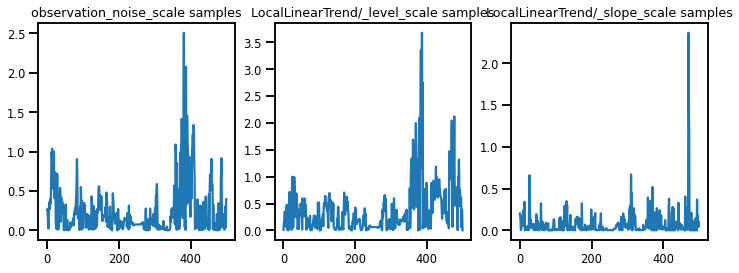

In [13]:
f = plt.figure(figsize=(12, 4))
for i, param in enumerate(sts_model.parameters):
  ax = f.add_subplot(1, len(sts_model.parameters), i + 1)
  ax.plot(samples[i])
  ax.set_title("{} samples".format(param.name))


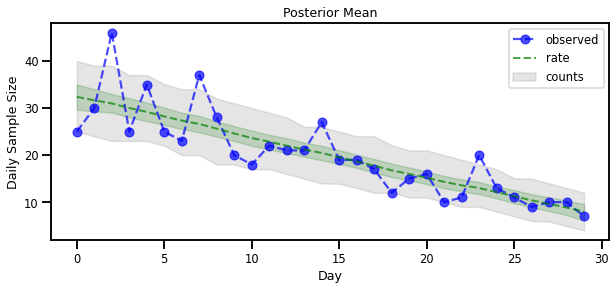

In [14]:
param_samples = samples[:-1]
unconstrained_rate_samples = samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), 
                                       [10, 90], axis=0)

_ = plt.plot(observed_counts, color="blue", ls='--', marker='o', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color="green", ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 30), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 30), pred_lower, pred_upper, color='grey', label='counts', alpha=0.2)
plt.xlabel("Day")
plt.ylabel("Daily Sample Size")
plt.title("Posterior Mean")
plt.legend()


In [15]:
def sample_forecasted_counts(sts_model, posterior_latent_rates,
                             posterior_params, num_steps_forecast,
                             num_sampled_forecasts):

  # Forecast the future latent unconstrained rates, given the inferred latent
  # unconstrained rates and parameters.
  unconstrained_rates_forecast_dist = tfp.sts.forecast(sts_model,
    observed_time_series=unconstrained_rate_samples,
    parameter_samples=posterior_params,
    num_steps_forecast=num_steps_forecast)

  # Transform the forecast to positive-valued Poisson rates.
  rates_forecast_dist = tfd.TransformedDistribution(
      unconstrained_rates_forecast_dist,
      positive_bijector)

  # Sample from the forecast model following the chain rule:
  # P(counts) = P(counts | latent_rates)P(latent_rates)
  sampled_latent_rates = rates_forecast_dist.sample(num_sampled_forecasts)
  sampled_forecast_counts = tfd.Poisson(rate=sampled_latent_rates).sample()

  return sampled_forecast_counts, sampled_latent_rates

forecast_samples, rate_samples = sample_forecasted_counts(
   sts_model,
   posterior_latent_rates=unconstrained_rate_samples,
   posterior_params=param_samples,
   # Days to forecast:
   num_steps_forecast=30,
   num_sampled_forecasts=100)


In [16]:
forecast_samples = np.squeeze(forecast_samples)


In [17]:
def plot_forecast_helper(data, forecast_samples, CI=90):
  """Plot the observed time series alongside the forecast."""
  plt.figure(figsize=(10, 4))
  forecast_median = np.median(forecast_samples, axis=0)

  num_steps = len(data)
  num_steps_forecast = forecast_median.shape[-1]

  plt.plot(np.arange(num_steps), data, lw=2, color='blue', linestyle='--', marker='o',
           label='Observed Data', alpha=0.7)

  forecast_steps = np.arange(num_steps, num_steps+num_steps_forecast)

  CI_interval = [(100 - CI)/2, 100 - (100 - CI)/2]
  lower, upper = np.percentile(forecast_samples, CI_interval, axis=0)

  plt.plot(forecast_steps, forecast_median, lw=2, ls='--', marker='o', color='orange',
           label=str(CI) + '% Forecast Interval', alpha=0.7)
  plt.fill_between(forecast_steps,
                   lower,
                   upper, color='orange', alpha=0.2)

  plt.xlim([0, num_steps+num_steps_forecast])
  ymin, ymax = min(np.min(forecast_samples), np.min(data)), max(np.max(forecast_samples), np.max(data))
  yrange = ymax-ymin
  plt.title("{}".format('Observed time series with ' + str(num_steps_forecast) + ' Day Forecast'))
  plt.xlabel('Day')
  plt.ylabel('Daily Sample Size')
  plt.legend()

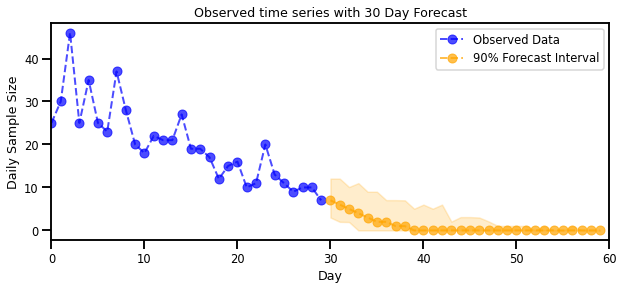

In [19]:
plot_forecast_helper(observed_counts, forecast_samples, CI=90)

In [20]:
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
    event_shape=pinned_model.event_shape,
    bijector=constraining_bijector)

In [21]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 1000 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

t0 = time.time()
losses = tfp.vi.fit_surrogate_posterior(pinned_model.unnormalized_log_prob,
                                        surrogate_posterior,
                                        optimizer=tf.optimizers.Adam(0.1),
                                        num_steps=num_variational_steps)
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))


Inference ran in 19.05s.


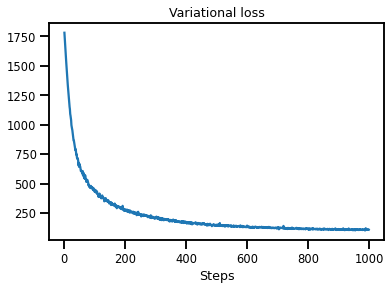

In [22]:
plt.plot(losses)
plt.title("Variational loss")
_ = plt.xlabel("Steps")

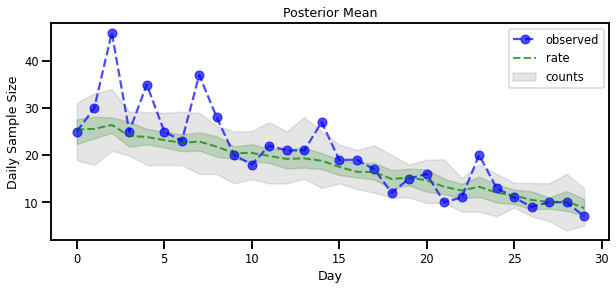

In [23]:
posterior_samples = surrogate_posterior.sample(50)
param_samples = posterior_samples[:-1]
unconstrained_rate_samples = posterior_samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(
    np.random.poisson(rate_samples), [10, 90], axis=0)

_ = plt.plot(observed_counts, color='blue', ls='--', marker='o',
             label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color='green',
             ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(
    np.arange(0, 30), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 30), pred_lower, pred_upper, color='grey',
    label='counts', alpha=0.2)
plt.xlabel('Day')
plt.ylabel('Daily Sample Size')
plt.title('Posterior Mean')
plt.legend()


In [24]:
forecast_samples, rate_samples = sample_forecasted_counts(
   sts_model,
   posterior_latent_rates=unconstrained_rate_samples,
   posterior_params=param_samples,
   # Days to forecast:
   num_steps_forecast=30,
   num_sampled_forecasts=100)


In [25]:
forecast_samples = np.squeeze(forecast_samples)


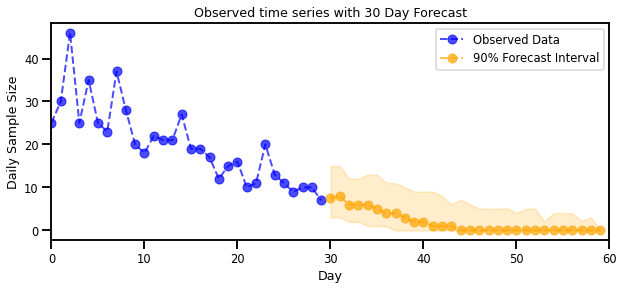

In [26]:
plot_forecast_helper(observed_counts, forecast_samples, CI=90)